In [177]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We will load all the images from the train, val, and test folders. With flow_from_directory, the images will have the labels attached so we do not need to specify the labels.

I have also moved some of the train images into the val folder since there was a pretty large imbalance. There were only around 10 images in the validation set.

I will also augment some of the images when we pull them in to prevent overfitting and potentially help more with the imbalance in the data

In [ ]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255, rotation_range=40, zoom_range=0.3, horizontal_flip=True,
                                width_shift_range=0.25, height_shift_range=0.25)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)
#train_labels = to_categorical(train_img.labels, num_classes=2)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#val_labels = to_categorical(val_img.labels, num_classes=2)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#test_labels = to_categorical(test_img.labels, num_classes=2)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Model 1
Here we will make a pretty shallow network to see how well it will work. Despite the images looking like grayscale, they are still 3 channel(rgb).

In [130]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

With this shallow network, we see that in each epoch, the model did not improve at all, with each accuracy, loss, etc being the exact same. This might mean the I may have messed up somewhere or the network is not deep enough and the model is making random gusses.

After tinkering with the data, it seems that include 'class_mode=binary' in the flow from directory function caused the model to work properly. 

In [132]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_hist = model.fit(train_img, 
                       epochs=10, 
                       validation_data=val_img, 
                       steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 119s 796ms/step - loss: 0.6769 - accuracy: 0.8535 - val_loss: 30.8740 - val_accuracy: 0.5000
Epoch 2/10
150/150 [==============================] - 119s 793ms/step - loss: 0.2652 - accuracy: 0.8850 - val_loss: 27.1030 - val_accuracy: 0.5000
Epoch 3/10
150/150 [==============================] - 119s 791ms/step - loss: 0.2312 - accuracy: 0.9030 - val_loss: 4.2252 - val_accuracy: 0.6250
Epoch 4/10
150/150 [==============================] - 118s 788ms/step - loss: 0.2039 - accuracy: 0.9128 - val_loss: 0.4310 - val_accuracy: 0.8125
Epoch 5/10
150/150 [==============================] - 118s 786ms/step - loss: 0.2102 - accuracy: 0.9170 - val_loss: 1.3040 - val_accuracy: 0.5677
Epoch 6/10
150/150 [==============================] - 118s 787ms/step - loss: 0.1841 - accuracy: 0.9268 - val_loss: 0.6230 - val_accuracy: 0.6823
Epoch 7/10
150/150 [==============================] - 119s 790ms/step - loss: 0.1751 - accuracy: 0.9285 - val_loss: 1.8846

When we evaluate on the test set, we see that the accuracy is not too great, not even 70 percent

In [133]:
model.evaluate(test_img)

20/20 [==============================] - 5s 240ms/step - loss: 0.8962 - accuracy: 0.6619


[0.896195650100708, 0.6618589758872986]

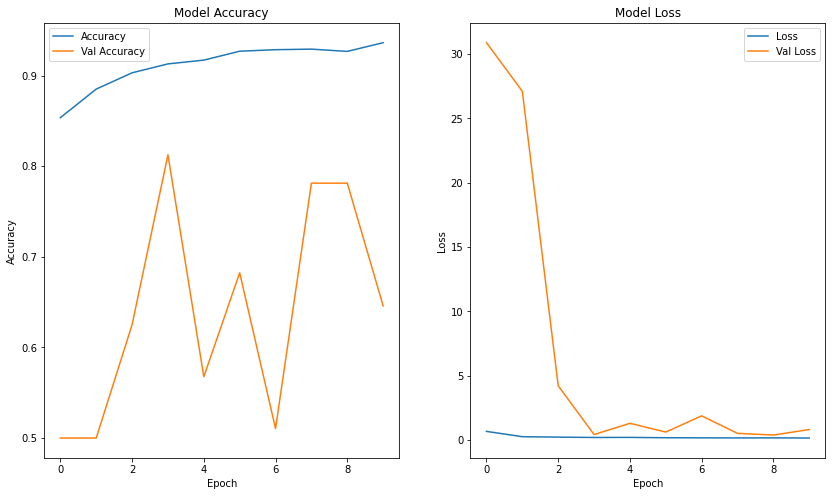

In [141]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 8))

ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch');

# Model 2
We see from the graphs that the model is very sporadic. We will try to fix this and improve the test accuracy by adding deeper layers. We will also bath normalize and add dropout to the layers.

In [ ]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

In [135]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(units=1, activation='sigmoid'))

In [136]:
model2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_37 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 109, 109, 64)      0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 54, 54, 64)      

We will monitor the accuracy and decrease learning rate if the accuracy plateaus

In [137]:
optimizer = keras.optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

model2.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model2_hist = model2.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch=150, callbacks=[reduce_lr, early_stop])

Epoch 1/10
150/150 [==============================] - 161s 1s/step - loss: 0.3385 - accuracy: 0.8424 - val_loss: 10.7092 - val_accuracy: 0.5000
Epoch 2/10
150/150 [==============================] - 159s 1s/step - loss: 0.2479 - accuracy: 0.8871 - val_loss: 19.7878 - val_accuracy: 0.5000
Epoch 3/10
150/150 [==============================] - 159s 1s/step - loss: 0.2249 - accuracy: 0.9076 - val_loss: 14.2776 - val_accuracy: 0.5000
Epoch 4/10
150/150 [==============================] - 159s 1s/step - loss: 0.1881 - accuracy: 0.9231 - val_loss: 4.3011 - val_accuracy: 0.5000
Epoch 5/10
150/150 [==============================] - 160s 1s/step - loss: 0.1923 - accuracy: 0.9252 - val_loss: 0.7220 - val_accuracy: 0.7656
Epoch 6/10
150/150 [==============================] - 160s 1s/step - loss: 0.1806 - accuracy: 0.9287 - val_loss: 0.3871 - val_accuracy: 0.8802
Epoch 7/10
150/150 [==============================] - 160s 1s/step - loss: 0.1737 - accuracy: 0.9327 - val_loss: 0.2991 - val_accuracy: 0.8

In [139]:
model2.evaluate(test_img)

20/20 [==============================] - 5s 256ms/step - loss: 0.5119 - accuracy: 0.8574


[0.5119263529777527, 0.8573718070983887]

Here we can see that the model has improved in accuracy a fair amount, but still lacking. We can plot and see how it performed over the epochs.

Text(0.5, 1.0, 'Model Loss')

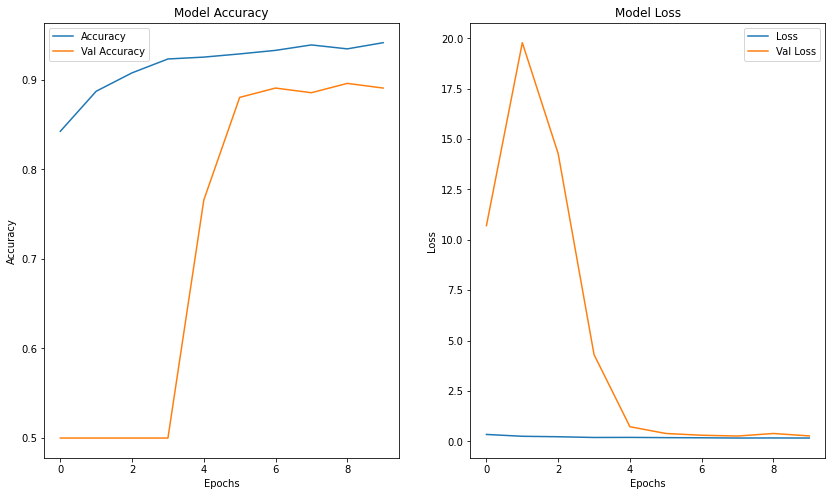

In [140]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model2_hist.history['accuracy'])
ax1.plot(model2_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model2_hist.history['loss'])
ax2.plot(model2_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Model 3
While the performance has increased, we can see there is still some overfitting. It is also not quite clear why the validation accuracy is stagnant for the first 3 epochs, and the validation loss skyrockets during the first 1-2 epochs. 

What I will try next is to add more regularization and more data augmentation to help with overfitting.

In [171]:
#Change batch size depending on scenario
b_size =  24

train_data = ImageDataGenerator(rescale=1/255, rotation_range=40, zoom_range=0.3, horizontal_flip=True,
                                width_shift_range=0.3, height_shift_range=0.3)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [172]:
model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Flatten())
model3.add(Dropout(0.6))
model3.add(Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)))
model3.add(Dense(units=1, activation='sigmoid'))

In [173]:
optimizer = keras.optimizers.Adam(lr=0.0001, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss', patience=4)

model3.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model3_hist = model3.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch= 5040/b_size, callbacks=[reduce_lr, early_stop])

Epoch 1/10
210/210 [==============================] - 98s 467ms/step - loss: 0.5484 - accuracy: 0.8312 - val_loss: 12.1294 - val_accuracy: 0.5000
Epoch 2/10
210/210 [==============================] - 97s 464ms/step - loss: 0.4293 - accuracy: 0.8679 - val_loss: 10.9338 - val_accuracy: 0.5000
Epoch 3/10
210/210 [==============================] - 98s 464ms/step - loss: 0.3981 - accuracy: 0.8873 - val_loss: 2.3275 - val_accuracy: 0.5000
Epoch 4/10
210/210 [==============================] - 97s 464ms/step - loss: 0.3811 - accuracy: 0.8933 - val_loss: 0.5063 - val_accuracy: 0.9062
Epoch 5/10
210/210 [==============================] - 98s 466ms/step - loss: 0.3792 - accuracy: 0.8901 - val_loss: 0.4708 - val_accuracy: 0.9062
Epoch 6/10
210/210 [==============================] - 98s 466ms/step - loss: 0.3771 - accuracy: 0.8921 - val_loss: 0.4839 - val_accuracy: 0.9115
Epoch 7/10
210/210 [==============================] - 101s 480ms/step - loss: 0.3710 - accuracy: 0.8917 - val_loss: 0.4410 - val

In [174]:
model3.evaluate(test_img)

26/26 [==============================] - 4s 166ms/step - loss: 0.5258 - accuracy: 0.8670


[0.5258132815361023, 0.8669871687889099]

Text(0.5, 1.0, 'Model Loss')

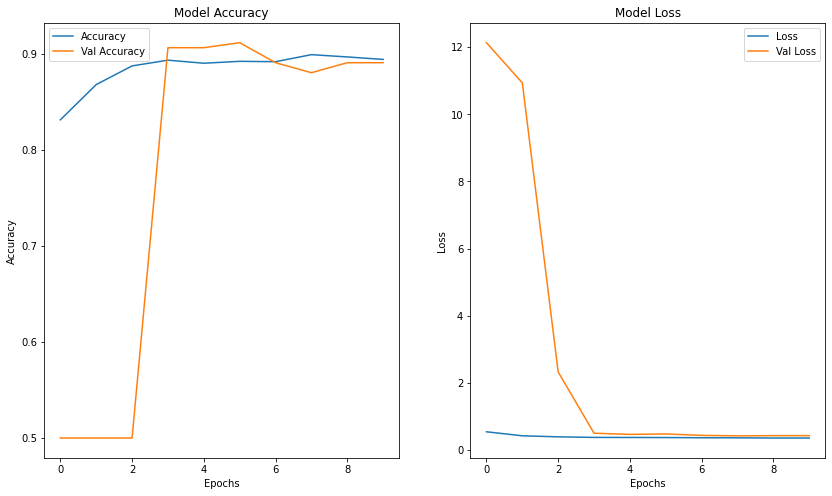

In [175]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model3_hist.history['accuracy'])
ax1.plot(model3_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model3_hist.history['loss'])
ax2.plot(model3_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Model 4
The accuracy and val accuracy are in line with one another, which means that there is no more overfitting. But the accuracy number itself is still under 90%, which is not ideal.

Now that a wall has been hit with my own model, I will explore using other models that have already been trained and perform extremely well. First, starting with VGG16. It turns out that adam optimizer does not work well with VGG16 so we will use SGD.

In [184]:
model4 = Sequential()
model4.add(VGG16(include_top = False, input_shape=(224, 224, 3)))

model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.SGD(lr=0.0001, clipnorm=1.0)
model4.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [185]:
model4_hist = model4.fit(train_img, epochs=2, steps_per_epoch=5040/b_size)

Epoch 1/2
210/210 [==============================] - 1523s 7s/step - loss: 0.5530 - accuracy: 0.7504
Epoch 2/2
210/210 [==============================] - 1539s 7s/step - loss: 0.5054 - accuracy: 0.7530
